# Attempt to forecast the price of MSFT by analyzing the prices of multiple stocks, including MSFT, over several consecutive days leading up to the target day.
#### N.B. Different setup from HW1

In [1]:
from torch.utils.data import DataLoader,Dataset

class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        y=self.Y[index+self.days]
        return x,y



In [2]:
# !pip install pandas
# !pip install yfinance
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [3]:
import torch.utils.data as data
import torch

stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
train_set_size = int(len(stockData)*0.7)
valid_set_size = int(len(stockData)*0.2)
test_set_size = len(stockData)-train_set_size-valid_set_size

train_set, valid_set, test_set = data.random_split(stockData,[train_set_size,valid_set_size,test_set_size],\
                                              generator=torch.Generator().manual_seed(42))

batch_size = train_set_size # use entire dataset as batch
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)  # input:(20,5), label:1
valid_dataloader = DataLoader(valid_set,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

# 1. Build a simple MLP to forecast MSFT price using PyTorch Lightning.

#### You have total freedom of your MLP. But your MLP should take the last five day ($5 \times 20=100$) prices as input and you have to add dropout into your network.

## 1a. Create a subclass of pytorch_lightning.LightningModule. It should include \_\_init\_\_, training_step, validation_step, configure_optimizers in the class. (6 points)

## 1b. Create a subclass of pytorch_lightning.LightningDataModule. It should include \_\_init\_\_, train_dataloader, and val_dataloader in the class. (4 points)

## 1c. Complete the rest of the code and train the model with 70% of the data. You should set aside 15% of the data each for validation and testing.  Show the training and validation MSE (5 points)

# 2. Construct a 1-D CNN to forecast MSFT stock price. You are free to use any design, but your network must consist of at least one convolutional layer and one dropout layer. You can also extend the duration leading up to the target day by modifying the "days" argument in the StockDataset. But "days" should not be larger than 32. (10 points)


# 3. Please try to enhance the performance of the previously created MLP or CNN by applying hyperparameter tuning. You can use tools such as W&B hyperparameter sweep, SMAP, Optuna, or similar packages to achieve this. You need to optimize at least two parameters, with the dropout rate being one of them. (5 points)












In [3]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-m3_bj8m0
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-m3_bj8m0
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit ca13f77eab5d8b85ee84eb9fd7484c324ba198b1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 M

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import copy
import yfinance as yf
import pandas as pd
import numpy as np

# ------------------------------
# Dataset and Data Preparation
# ------------------------------
class StockDataset(Dataset):
    def __init__(self, X, Y, days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days  # days ahead for prediction

    def __len__(self):
        return len(self.Y) - self.days

    def __getitem__(self, index):
        x = self.X[:, index:index + self.days]  # shape: (num_stocks, days)
        y = self.Y[index + self.days]
        return x, y

def get_price(tick, start='2020-01-01', end=None):
    return yf.Ticker(tick).history(start=start, end=end)['Close']

def get_prices(tickers, start='2020-01-01', end=None):
    df = pd.DataFrame()
    for s in tickers:
        df[s] = get_price(s, start, end)
    return df

# Define tickers
feature_stocks = ['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock = 'msft'
start_date = '2020-01-01'

allX = get_prices(feature_stocks, start=start_date)
ally = get_prices([predict_stock], start=start_date)

# Create dataset: note that we transpose allX so that each column is a time step.
stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),
                         ally.to_numpy().astype(np.float32),
                         days=5)

# Split dataset: 70% train, 15% valid, 15% test.
dataset_size = len(stockData)
train_size = int(dataset_size * 0.70)
valid_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - valid_size

train_set, valid_set, test_set = random_split(stockData, [train_size, valid_size, test_size],
                                                generator=torch.Generator().manual_seed(42))

batch_size = 64  # you can adjust the batch size as needed




In [5]:
# ------------------------------
# Lightning Data Module
# ------------------------------
class StockDataModule(pl.LightningDataModule):
    def __init__(self, train_set, valid_set, test_set, batch_size):
        super().__init__()
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False)

data_module = StockDataModule(train_set, valid_set, test_set, batch_size)

# ------------------------------
# Lightning Module: MLP Forecasting Model
# ------------------------------
class MSFTForecastingMLP(pl.LightningModule):
    def __init__(self):
        super(MSFTForecastingMLP, self).__init__()
        # The input is 5 days of data for 20 stocks: 5*20 = 100 features.
        self.model = nn.Sequential(
            nn.Flatten(),              # Flatten input (20, 5) -> (100,)
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)           # Output single forecast value
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# ------------------------------
# Callback to Record Loss History
# ------------------------------
class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_validation_epoch_end(self, trainer, pl_module):
        # trainer.callback_metrics is a dictionary that stores the logged metrics.
        # Ensure the keys match those we logged.
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")
        if train_loss is not None and val_loss is not None:
            self.train_losses.append(train_loss.item())
            self.val_losses.append(val_loss.item())


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 8.6 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


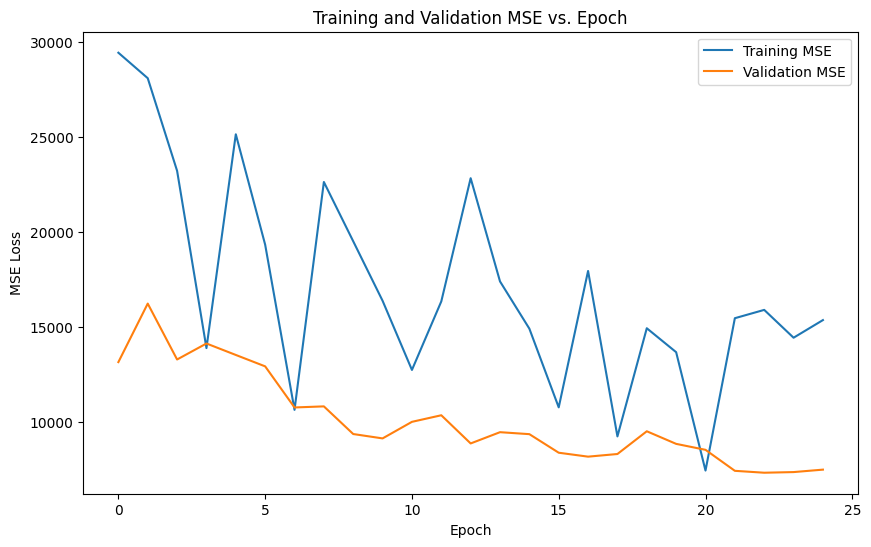

In [7]:

# Instantiate model and callback
model = MSFTForecastingMLP()
loss_history = LossHistory()

# ------------------------------
# Training
# ------------------------------
# Set up PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=25, callbacks=[loss_history], log_every_n_steps=1)

# Train the model using the data module (which provides 70% training and 15% validation data)
trainer.fit(model, datamodule=data_module)

# ------------------------------
# Plotting Training and Validation MSE vs Epoch
# ------------------------------
plt.figure(figsize=(10,6))
plt.plot(loss_history.train_losses, label='Training MSE')
plt.plot(loss_history.val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE vs. Epoch')
plt.legend()
plt.show()